# **Main Installation**

In [ ]:
!pip install ndlinear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin


> This block installs the `ndlinear` library, which is the core component developed by Ensemble that this project utilizes. It provides the `NdLinear` layer used later in the model definitions.

# **CIFAR10-NdLinear**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import argparse
import os

# Import the NdLinear module from the provided file.
from ndlinear import NdLinear

from sklearn.metrics import classification_report, confusion_matrix
import time

> This section imports necessary libraries:
> *   `torch`, `torch.nn`, `torch.nn.functional`, `torch.optim`: Core PyTorch components for building neural networks, defining activation functions, loss functions, and optimizers.
> *   `torchvision.datasets`, `torchvision.transforms`: Used for loading standard datasets like CIFAR-10 and applying data augmentation/normalization.
> *   `torch.utils.data.DataLoader`: Manages loading data in batches during training and testing.
> *   `argparse`: Handles command-line arguments for configuring the script (e.g., batch size, epochs).
> *   `os`: Provides operating system functionalities, used here for creating directories.
> *   `ndlinear.NdLinear`: Imports the custom N-dimensional linear layer implementation.
> *   `sklearn.metrics`: Used for calculating evaluation metrics like classification reports and confusion matrices.
> *   `time`: Used for timing operations, specifically inference time.


### **CIFAR10 Experiment: Model Definition**

In [ ]:
class NdLinearCIFAR10(nn.Module):
    """
    A CNN model for CIFAR-10 that integrates NdLinear.

    The network performs the following steps:
    1. Convolutional feature extraction.
    2. Spatial downsampling via max pooling.
    3. Rearrangement of feature map dimensions so that NdLinear can act on the
       [height, width, channels] layout.
    4. NdLinear replaces a conventional fully connected layer and projects
       the features into a new multi-space representation.
    5. The resulting tensor is flattened and classified.
    """
    def __init__(self, ndlinear_hidden_size=(4, 4, 128)):
        super(NdLinearCIFAR10, self).__init__()
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Out: 32x32x32
        self.pool = nn.MaxPool2d(2, 2)  # Downsample by factor of 2: 32x16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Out: 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2)  # Downsample: 64x8x8

        # After conv layers, tensor shape: [batch_size, 64, 8, 8]
        # Rearrange to [batch_size, 8, 8, 64] so that the spatial dimensions are in front.
        # Define NdLinear which takes an input shape and projects it into a new shape.
        # In this example, input_dims=(8, 8, 64) and we project to hidden dims (4, 4, 128)
        self.ndlinear = NdLinear((8, 8, 64), ndlinear_hidden_size)

        # Final classification layer.
        # The output from NdLinear is of shape [batch_size, 4, 4, 128] -> flatten to 4*4*128 = 2048
        self.fc = nn.Linear(4 * 4 * 128, 10)

    def forward(self, x):
        # Apply convolutional layers and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # x shape: [batch_size, 64, 8, 8]
        # Permute dimensions to [batch_size, 8, 8, 64] for NdLinear compatibility
        x = x.permute(0, 2, 3, 1)
        # Apply NdLinear transformation
        x = self.ndlinear(x)  # New shape: [batch_size, 4, 4, 128]
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

        # Compute accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    avg_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


> This defines the `NdLinearCIFAR10` neural network class, inheriting from `torch.nn.Module`.
> The `__init__` method sets up the layers:
> *   `conv1`, `pool`, `conv2`, `pool2`: Standard 2D convolutional and max-pooling layers commonly used in image classification tasks. They extract features and progressively reduce the spatial dimensions of the input image (from 32x32 to 8x8).
> *   `self.ndlinear`: This is the key component. It instantiates the `NdLinear` layer.
>     *   `input_dims=(8, 8, 64)`: Specifies the expected shape of the input tensor *excluding the batch dimension*. This shape corresponds to the `(height, width, channels)` dimensions of the feature map after the convolutions and necessary permutation.
>     *   `ndlinear_hidden_size=(4, 4, 128)`: Defines the desired output shape from the `NdLinear` layer (again, excluding batch size). It effectively replaces a traditional flatten and fully connected layer, operating directly on the multi-dimensional feature map and projecting it to a new multi-dimensional space.
> *   `self.fc`: A standard fully connected (`Linear`) layer that takes the flattened output of `NdLinear` (size `4 * 4 * 128 = 2048`) and produces 10 output logits, one for each CIFAR-10 class.
> The `forward` method defines the data flow through the network:
 1.  The input `x` passes through the convolutional and pooling layers with ReLU activations.
 2.  `x.permute(0, 2, 3, 1)`: The tensor dimensions are rearranged. PyTorch Conv2d outputs `[batch, channels, height, width]`. This permutation changes it to `[batch, height, width, channels]` to match the `input_dims` expected by the `NdLinear` layer instance.
 3.  `self.ndlinear(x)`: The permuted feature map is passed through the `NdLinear` layer, transforming it to the specified `hidden_size`.
 4.  `x.view(x.size(0), -1)`: The multi-dimensional output of `NdLinear` is flattened into a 1D vector per batch item.
 5.  `self.fc(x)`: The flattened vector is passed through the final fully connected layer to get class scores.
 6.  The resulting logits are returned.


### **CIFAR10 Experiment: Training and Testing Functions**

In [ ]:
def evaluate(model, device, data_loader):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    all_preds, all_targets = [], []
    start_time = time.time()
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum')

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += preds.eq(target).sum().item()
            total += target.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    inference_time = time.time() - start_time
    avg_loss = total_loss / total
    accuracy = correct / total * 100
    return avg_loss, accuracy, all_targets, all_preds, inference_time


def main():
    parser = argparse.ArgumentParser(description="CIFAR-10 with NdLinear")
    parser.add_argument("--batch_size", type=int, default=64, help="training batch size")
    parser.add_argument("--test_batch_size", type=int, default=1000, help="test batch size")
    parser.add_argument("--epochs", type=int, default=20, help="number of epochs")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
    parser.add_argument("--data_dir", type=str, default="./data", help="data directory")
    parser.add_argument("--no_cuda", action="store_true", default=False, help="disable CUDA")
    parser.add_argument("--seed", type=int, default=42, help="random seed")
    parser.add_argument("--report_file", type=str, default="classification_report.txt", help="path to save the classification report")

    # Ignore extra flags from notebook environments
    args, _ = parser.parse_known_args()

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")

    print(f"Using device: {device}")
    # Data transforms
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Datasets and loaders
    train_dataset = datasets.CIFAR10(root=args.data_dir, train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root=args.data_dir, train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=4)

    model = NdLinearCIFAR10().to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    print(f"Total trainable parameters: {count_parameters(model)}")
    os.makedirs("checkpoints", exist_ok=True)

    best_acc, best_epoch = 0.0, 0
    # Training loop
    for epoch in range(1, args.epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        val_loss, val_acc, _, _, _ = evaluate(model, device, test_loader)
        print(f"Validation after epoch {epoch}: Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        ckpt_path = f"checkpoints/ndlinear_cifar10_epoch{epoch}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")
        if val_acc > best_acc:
            best_acc, best_epoch = val_acc, epoch
            best_ckpt = ckpt_path

    print(f"Best validation accuracy: {best_acc:.2f}% at epoch {best_epoch}")

    # Final evaluation and report
    test_loss, test_acc, targets, preds, inference_time = evaluate(model, device, test_loader)
    print(f"Final Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    print(f"Total inference time on test set: {inference_time:.2f}s")

    report = classification_report(targets, preds)
    conf_mat = confusion_matrix(targets, preds)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_mat)

    # Save report
    with open(args.report_file, 'w') as f:
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(str(conf_mat))
    print(f"Saved classification report to {args.report_file}")


if __name__ == "__main__":
    main()

Using device: cpu
Total trainable parameters: 48274


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train Loss: 1.6238, Accuracy: 40.90%
Validation after epoch 1: Loss: 1.2616, Accuracy: 55.20%
Saved checkpoint: checkpoints/ndlinear_cifar10_epoch1.pth
Epoch 2: Train Loss: 1.3057, Accuracy: 53.63%
Validation after epoch 2: Loss: 1.1008, Accuracy: 61.61%
Saved checkpoint: checkpoints/ndlinear_cifar10_epoch2.pth
Epoch 3: Train Loss: 1.1758, Accuracy: 58.58%
Validation after epoch 3: Loss: 0.9996, Accuracy: 65.24%
Saved checkpoint: checkpoints/ndlinear_cifar10_epoch3.pth
Epoch 4: Train Loss: 1.0999, Accuracy: 61.11%
Validation after epoch 4: Loss: 0.9330, Accuracy: 67.92%
Saved checkpoint: checkpoints/ndlinear_cifar10_epoch4.pth
Epoch 5: Train Loss: 1.0407, Accuracy: 63.82%
Validation after epoch 5: Loss: 0.8993, Accuracy: 68.80%
Saved checkpoint: checkpoints/ndlinear_cifar10_epoch5.pth
Epoch 6: Train Loss: 0.9968, Accuracy: 65.17%
Validation after epoch 6: Loss: 0.8619, Accuracy: 70.38%
Saved checkpoint: checkpoints/ndlinear_cifar10_epoch6.pth
Epoch 7: Train Loss: 0.9651, Accur

> This function defines the training loop for a single epoch:
> 1.  `model.train()`: Sets the model to training mode (enables dropout, batch normalization updates, etc.).
> 2.  Iterates through batches of data provided by `train_loader`.
> 3.  Moves data and targets to the specified `device` (CPU or GPU).
> 4.  `optimizer.zero_grad()`: Clears gradients from the previous iteration.
> 5.  `output = model(data)`: Performs the forward pass to get predictions.
> 6.  `loss = F.cross_entropy(...)`: Calculates the loss between predictions and true targets.
> 7.  `loss.backward()`: Computes gradients of the loss with respect to model parameters.
> 8.  `optimizer.step()`: Updates model parameters based on the computed gradients.
> 9.  Accumulates the loss and calculates running accuracy within the epoch.
> 10. Prints the average loss and accuracy for the epoch and returns these values.

# **Additional Dataset Experiments**

# **UTKFace Facial Attribute Prediction - NdLinear**

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00


> This installs the `mlflow` library, used for tracking machine learning experiments, logging parameters, metrics, and artifacts.

In [ ]:
# 1. Imports & Setup
import os
import cv2
import glob
import torch
import mlflow
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score
from ndlinear import NdLinear  # assuming you've already added this
from torchvision import transforms
from tqdm import tqdm

> Imports necessary libraries for the UTKFace experiment:
> *   `cv2`: OpenCV library, used for reading and resizing images.
> *   `glob`: Used for finding files matching a specific pattern (finding all image files).
> *   `mlflow`: For experiment tracking.
> *   `numpy`: Numerical Python library.
> *   `sklearn.model_selection.train_test_split`: For splitting data into training and testing sets.
> *   `sklearn.metrics`: Includes metrics like Mean Absolute Error (MAE) for age regression, accuracy, and F1-score for classification tasks (gender, race).
> *   `tqdm`: Provides progress bars for loops.
> *   Other imports (`torch`, `torchvision`, `ndlinear`, etc.) are similar to the CIFAR-10 experiment.

In [ ]:
#!/bin/bash
!curl -L -o utkface-new.zip\
  https://www.kaggle.com/api/v1/datasets/download/jangedoo/utkface-new

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  331M  100  331M    0     0   129M      0  0:00:02  0:00:02 --:--:--  158M


In [ ]:
!unzip /content/utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

> These shell commands download the UTKFace dataset (likely from Kaggle, requiring appropriate setup/authentication if run outside specific environments like Kaggle kernels) and then unzip the downloaded archive.


### **UTKFace Experiment: Data Loading**

In [ ]:
# 2. UTKFace Dataset Loader
class UTKFaceDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        file_name = os.path.basename(path)
        try:
            age, gender, race = map(int, file_name.split("_")[:3])
        except:
            age, gender, race = 0, 0, 0  # fallback for malformed files

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(age, dtype=torch.float32), gender, race

> Defines a custom PyTorch `Dataset` for the UTKFace dataset:
> *   `__init__`: Stores the list of image file paths and any transformations to apply.
> *   `__len__`: Returns the total number of images.
> *   `__getitem__`: Loads a single data sample:
>     *   Extracts `age`, `gender`, and `race` labels by parsing the filename (format: `[age]_[gender]_[race]_*.jpg`). Includes basic error handling for filenames that don't match the pattern.
>     *   Loads the image using `cv2.imread`.
>     *   Converts the image from BGR (OpenCV's default) to RGB format.
>     *   Resizes the image to a fixed size (128x128).
>     *   Applies the specified `transform` (e.g., ToTensor, Normalization).
>     *   Returns the transformed image tensor, age (as a float tensor for potential regression), gender (int), and race (int).

In [ ]:
# 3. Data Prep
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Update the path if needed and ensure it's correct
all_images = glob.glob("/content/utkface_aligned_cropped/UTKFace/*.jpg")  # Replace with the actual path
# Check if all_images is empty
if not all_images:
    print("Error: No images found in the specified directory. Please check the path.")
    # Handle the error or exit gracefully
else:
    train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

    train_dataset = UTKFaceDataset(train_files, transform)
    test_dataset = UTKFaceDataset(test_files, transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

> Prepares the data for training and testing:
> *   Defines the image `transform`: Convert image to PyTorch tensor and normalize pixel values to be roughly in the range [-1, 1].
> *   Uses `glob.glob` to find all `.jpg` image files in the dataset directory. Includes an essential check to ensure images were actually found.
> *   Splits the list of image file paths into training (80%) and testing (20%) sets using `train_test_split` with a fixed `random_state` for reproducibility.
> *   Creates instances of the `UTKFaceDataset` for both training and testing sets, applying the defined transform.
> *   Creates `DataLoader` instances for efficient batch loading during training (with shuffling) and testing (without shuffling).

In [ ]:
class NdLinearUTKFace(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) load full resnet and strip off avgpool+fc to get a [B,512,4,4] feature map:
        resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # 2) now NdLinear expects input_dims=(4,4,512)
        self.nd = NdLinear((4, 4, 512), (2, 2, 128))

        # 3) heads as before
        self.age_head    = nn.Linear(2*2*128, 1)
        self.gender_head = nn.Linear(2*2*128, 2)
        self.race_head   = nn.Linear(2*2*128, 5)

    def forward(self, x):
        # x: [B,3,128,128] → backbone → [B,512,4,4]
        x = self.backbone(x)
        # permute to [B,4,4,512] so NdLinear can act on (4,4,512)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = self.nd(x)                   # → [B,2,2,128]
        x = x.view(x.size(0), -1)        # → [B,512]
        return self.age_head(x), self.gender_head(x), self.race_head(x)


> Defines the `NdLinearUTKFace` model for multi-task prediction (age, gender, race):
> *   `__init__`:
>     *   Loads a pre-trained ResNet18 model using `torchvision.models.resnet18`. `weights=...` ensures loading weights trained on ImageNet.
>     *   `self.backbone = nn.Sequential(*list(resnet.children())[:-2])`: Creates a feature extractor by taking all layers of the ResNet *except* the final average pooling and fully connected layers. For a 128x128 input, this backbone outputs a feature map of shape `[batch_size, 512, 4, 4]`.
>     *   `self.nd = NdLinear((4, 4, 512), (2, 2, 128))`: Defines the `NdLinear` layer. It takes the `(height=4, width=4, channels=512)` feature map (after permutation) and projects it to a `(2, 2, 128)` multi-dimensional space.
>     *   `self.age_head`, `self.gender_head`, `self.race_head`: Defines three separate linear ("fully connected") layers, acting as prediction heads. Each takes the flattened output of the `NdLinear` layer (`2 * 2 * 128 = 512` features) and outputs predictions for its specific task (1 value for age, 2 logits for gender, 5 logits for race).
> *   `forward`:
>     *   Passes the input image `x` through the `backbone` to get feature maps.
>     *   `x.permute(0, 2, 3, 1).contiguous()`: Permutes the feature map dimensions from `[B, C, H, W]` to `[B, H, W, C]` to match `NdLinear`'s expected `input_dims`. `.contiguous()` ensures the tensor is stored in contiguous memory after permuting, which is often required by subsequent operations like `view`.
>     *   Passes the permuted features through `self.nd`.
>     *   `x.view(x.size(0), -1)`: Flattens the output of `NdLinear` into a vector of size 512 for each item in the batch.
>     *   Passes the flattened features through each of the prediction heads.
>     *   Returns the outputs from the three heads as a tuple.

In [ ]:
# 5. Training + MLflow Logging
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NdLinearUTKFace().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
mlflow.set_experiment("UTKFace-NdLinear")

with mlflow.start_run():
    for epoch in range(5):  # keep it short for now
        model.train()
        age_losses, gender_losses, race_losses = [], [], []

        for X, age, gender, race in tqdm(train_loader):
            X, age = X.to(device), age.to(device)
            gender = gender.to(device)
            race = race.to(device)

            optimizer.zero_grad()
            age_out, gender_out, race_out = model(X)

            loss_age = F.mse_loss(age_out.squeeze(1), age)
            loss_gender = F.cross_entropy(gender_out, gender)
            loss_race = F.cross_entropy(race_out, race)
            loss = loss_age + loss_gender + loss_race
            loss.backward()
            optimizer.step()

            age_losses.append(loss_age.item())
            gender_losses.append(loss_gender.item())
            race_losses.append(loss_race.item())

        mlflow.log_metric("loss_age", np.mean(age_losses), step=epoch)
        mlflow.log_metric("loss_gender", np.mean(gender_losses), step=epoch)
        mlflow.log_metric("loss_race", np.mean(race_losses), step=epoch)
        print(f"Epoch {epoch+1} complete")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]
2025/04/20 16:16:40 INFO mlflow.tracking.fluent: Experiment with name 'UTKFace-NdLinear' does not exist. Creating a new experiment.
100%|██████████| 297/297 [00:34<00:00,  8.52it/s]


Epoch 1 complete


100%|██████████| 297/297 [00:33<00:00,  8.94it/s]


Epoch 2 complete


100%|██████████| 297/297 [00:33<00:00,  8.89it/s]


Epoch 3 complete


100%|██████████| 297/297 [00:33<00:00,  8.83it/s]


Epoch 4 complete


100%|██████████| 297/297 [00:33<00:00,  8.75it/s]

Epoch 5 complete


> This block handles the training process and integrates MLflow logging:
> 1.  Sets up the `device`, instantiates the `NdLinearUTKFace` model, moves it to the device, and defines an Adam optimizer with a learning rate of 1e-4.
> 2.  `mlflow.set_experiment(...)`: Organizes runs under a specific experiment name in MLflow.
> 3.  `with mlflow.start_run()`: Creates a new run context. All logging within this block will be associated with this run.
> 4.  The training loop runs for a fixed number of epochs (5 in this case).
> 5.  Inside the epoch loop:
>     *   Sets the model to training mode.
>     *   Iterates through the `train_loader` using `tqdm` for a progress bar.
>     *   Moves data (`X`, `age`, `gender`, `race`) to the `device`.
>     *   Performs the standard training steps: zero gradients, forward pass, loss calculation, backpropagation, and optimizer step.
>     *   Calculates separate losses for each task: `mse_loss` for age (regression) and `cross_entropy` for gender and race (classification). The `.squeeze(1)` on `age_out` removes an unnecessary dimension for MSE calculation.
>     *   Combines the individual losses into a single `loss` value (simple sum here, could be weighted).
>     *   Tracks the individual losses for logging.
> 6.  After each epoch, calculates the average loss for each task and logs it to MLflow using `mlflow.log_metric`, associating it with the current epoch number (`step=epoch`).

In [ ]:
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

# 6. Testing + MLflow Logging
model.eval()
y_true_age, y_pred_age = [], []
y_true_gender, y_pred_gender = [], []
y_true_race, y_pred_race = [], []

with torch.no_grad():
    for X, age, gender, race in test_loader:
        X = X.to(device)
        age_out, gender_out, race_out = model(X)

        # gather true / pred
        y_true_age   .extend(age.numpy().tolist())
        y_pred_age   .extend(age_out.cpu().squeeze().numpy().tolist())
        y_true_gender.extend(gender.numpy().tolist())
        y_pred_gender.extend(gender_out.argmax(dim=1).cpu().numpy().tolist())
        y_true_race  .extend(race.numpy().tolist())
        y_pred_race  .extend(race_out.argmax(dim=1).cpu().numpy().tolist())

# compute metrics
test_age_mae     = mean_absolute_error(y_true_age, y_pred_age)
test_gender_acc  = accuracy_score(     y_true_gender, y_pred_gender)
test_race_f1     = f1_score(           y_true_race,   y_pred_race, average='macro')

print(f"🔹 Test Age MAE:     {test_age_mae:.4f}")
print(f"🔹 Test Gender Acc:  {test_gender_acc:.4f}")
print(f"🔹 Test Race  F1:    {test_race_f1:.4f}")

# log to MLflow
mlflow.log_metric("test_age_mae",    test_age_mae)
mlflow.log_metric("test_gender_acc", test_gender_acc)
mlflow.log_metric("test_race_f1",    test_race_f1)

# classification reports
gender_report = classification_report(y_true_gender, y_pred_gender, target_names=["Male","Female"])
race_report   = classification_report(y_true_race,   y_pred_race, target_names=[str(i) for i in range(5)])

print("\n📝 Gender Classification Report:\n", gender_report)
print("\n📝 Race Classification Report:\n",   race_report)

# save and log reports as artifacts
with open("gender_report.txt", "w") as f:
    f.write(gender_report)
with open("race_report.txt", "w") as f:
    f.write(race_report)

mlflow.log_artifact("gender_report.txt")
mlflow.log_artifact("race_report.txt")

# optionally confusion matrices
cm_gender = confusion_matrix(y_true_gender, y_pred_gender)
cm_race   = confusion_matrix(y_true_race,   y_pred_race)

print("\n🔢 Gender Confusion Matrix:\n", cm_gender)
print("\n🔢 Race   Confusion Matrix:\n", cm_race)

# end the MLflow run
mlflow.end_run()


🔹 Test Age MAE:     5.4386
🔹 Test Gender Acc:  0.8429
🔹 Test Race  F1:    0.3888

📝 Gender Classification Report:
               precision    recall  f1-score   support

        Male       0.84      0.85      0.85      2425
      Female       0.84      0.83      0.84      2317

    accuracy                           0.84      4742
   macro avg       0.84      0.84      0.84      4742
weighted avg       0.84      0.84      0.84      4742


📝 Race Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.86      0.69      1949
           1       0.58      0.76      0.66       934
           2       0.50      0.31      0.38       675
           3       0.50      0.13      0.21       824
           4       0.00      0.00      0.00       360

    accuracy                           0.57      4742
   macro avg       0.43      0.41      0.39      4742
weighted avg       0.51      0.57      0.51      4742


🔢 Gender Confusion Matrix:
 [[2063  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



> This section evaluates the trained model on the test set:
> 1.  Imports additional `sklearn.metrics` if not already done.
> 2.  Sets the model to evaluation mode (`model.eval()`).
> 3.  Initializes empty lists to store true labels and model predictions for each task.
> 4.  Disables gradient calculation using `with torch.no_grad()`.
> 5.  Iterates through the `test_loader`.
> 6.  Moves input data `X` to the device and performs a forward pass.
> 7.  Appends the true labels and the model's predictions to their respective lists.
>     *   For age (regression), the raw output (`age_out`) is collected after moving to CPU and squeezing.
>     *   For gender and race (classification), `argmax(dim=1)` is used on the logits (`gender_out`, `race_out`) to get the index of the predicted class. `.cpu().numpy().tolist()` converts the tensors to lists of numbers.
> Calculates and logs overall evaluation metrics:
> 1.  Calculates the Mean Absolute Error (MAE) between true and predicted ages using `mean_absolute_error`.
> 2.  Calculates the accuracy for gender prediction using `accuracy_score`.
> 3.  Calculates the macro-averaged F1-score for race prediction using `f1_score`. Macro averaging calculates the F1 for each class independently and then averages them, treating all classes equally.
> 4.  Prints the calculated metrics.
> 5.  Logs these metrics to the active MLflow run using `mlflow.log_metric`.
> Generates, prints, saves, and logs detailed classification reports:
> 1.  Uses `sklearn.metrics.classification_report` to generate reports showing precision, recall, and F1-score for each class in the gender and race tasks. `target_names` provides meaningful labels for the classes.
> 2.  Prints the generated reports to the console.
> 3.  Saves each report to a text file (`gender_report.txt`, `race_report.txt`).
> 4.  Logs these text files as *artifacts* to the MLflow run using `mlflow.log_artifact`. Artifacts are files associated with the run (like reports, plots, or model files).
> Calculates and prints confusion matrices and ends the MLflow run:
> 1.  Uses `sklearn.metrics.confusion_matrix` to compute confusion matrices for gender and race predictions.
> 2.  Prints the matrices to the console. (These could also be visualized and saved/logged as artifacts like the reports).
> 3.  `mlflow.end_run()`: Explicitly marks the end of the current MLflow run. Logging after this point would start a new run or require starting one manually.



# **UCF101 video action recognition using NdLinear**

In [ ]:
!pip install av mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00


> Installs the `av` library (which provides Python bindings for FFmpeg, necessary for efficient video decoding by libraries like `torchvision.io`) and `mlflow`.

In [ ]:
#!/bin/bash
!curl -L -o ucf101-action-recognition.zip\
  https://www.kaggle.com/api/v1/datasets/download/matthewjansen/ucf101-action-recognition

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6682M  100 6682M    0     0  91.0M      0  0:01:13  0:01:13 --:--:--  125M


In [ ]:
!mkdir UCF101 && cd UCF101 && unzip /content/ucf101-action-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/PlayingViolin/v_PlayingViolin_g04_c02.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g04_c03.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g04_c04.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g05_c01.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g05_c02.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g05_c03.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g05_c04.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g06_c02.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g06_c03.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g07_c01.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g07_c02.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g07_c03.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g08_c03.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g08_c04.avi  
  inflating: train/PlayingViolin/v_PlayingViolin_g09_c01.avi  
  in

> Downloads the UCF101 action recognition dataset archive (again, likely from Kaggle), creates a directory named `UCF101`, changes into it, and unzips the archive there. This sets up the expected directory structure for the dataset loader.

In [ ]:
!tree UCF101/ > /content/ucf101_tree_output.txt

> Runs the `tree` command to list the contents of the `UCF101` directory in a tree-like format and saves the output to a text file. This is useful for verifying the dataset structure after unzipping.

In [ ]:
# ── 1. Imports & Setup ──────────────────────────────────────────────────────
import os
import mlflow
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torchvision import transforms
from torchvision.datasets import UCF101
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from ndlinear import NdLinear
from tqdm import tqdm

# MLflow experiment
mlflow.set_experiment("UCF101-NdLinear")

2025/04/21 02:32:58 INFO mlflow.tracking.fluent: Experiment with name 'UCF101-NdLinear' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/390295020592289763', creation_time=1745202778182, experiment_id='390295020592289763', last_update_time=1745202778182, lifecycle_stage='active', name='UCF101-NdLinear', tags={}>

> Imports necessary libraries for the video action recognition task and sets up MLflow:
> *   Includes standard libraries (`os`, `torch`, `numpy`, `sklearn`, `tqdm`).
> *   Imports `torchvision.transforms` and `DataLoader`. Note that while `torchvision.datasets.UCF101` is imported, a custom dataset class `UCF101Dataset` is defined and used later, likely for more control over video loading and frame sampling.
> *   Imports `NdLinear`.
> *   Sets the MLflow experiment name to "UCF101-NdLinear".

### **UCF101 Experiment: Data Loading**

In [ ]:
# ── 2. Data: Custom UCF101 Dataset ───────────────────────────────────────────
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, io

class UCF101Dataset(Dataset):
    def __init__(self, root_dir, split='train', frames_per_clip=4, transform=None):
        """
        root_dir/
          ├── train/
          │    ├── ApplyEyeMakeup/*.avi
          │    └── ...
          └── test/
               ├── ApplyEyeMakeup/*.avi
               └── ...
        """
        self.frames_per_clip = frames_per_clip
        self.transform = transform
        split_dir = os.path.join(root_dir, split)
        # collect class names
        self.classes = sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # build list of (video_path, label_idx)
        self.samples = []
        for cls in self.classes:
            pattern = os.path.join(split_dir, cls, '*.avi')
            for p in glob.glob(pattern):
                self.samples.append((p, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # read all frames (T, H, W, C) as uint8 tensor
        video, _, _ = io.read_video(path, pts_unit='sec')
        # video.shape == (T, H, W, 3)
        T = video.shape[0]
        # choose evenly spaced frame indices
        if T >= self.frames_per_clip:
            indices = np.linspace(0, T - 1, self.frames_per_clip, dtype=int)
        else:
            # pad by repeating last frame
            pad = list(range(T)) + [T - 1] * (self.frames_per_clip - T)
            indices = np.array(pad, dtype=int)[:self.frames_per_clip]

        clip = video[indices]               # (frames_per_clip, H, W, 3)
        # permute to (T, 3, H, W)
        clip = clip.permute(0, 3, 1, 2).float() / 255.0

        # apply transform to each frame if provided
        if self.transform:
            # transforms expect PIL or tensor [C,H,W], so map per frame
            clip = torch.stack([self.transform(frame) for frame in clip], dim=0)

        return clip, label

# ── 2b. Instantiate DataLoaders ──────────────────────────────────────────────
DATA_ROOT = "/content/UCF101"   # adjust to your path
frames = 4

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

train_ds = UCF101Dataset(DATA_ROOT, split='train', frames_per_clip=frames, transform=transform)
test_ds  = UCF101Dataset(DATA_ROOT, split='test',  frames_per_clip=frames, transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=4)

num_classes = len(train_ds.classes)
print(f"→ {len(train_ds)} training clips, {len(test_ds)} test clips, {num_classes} classes")


→ 10055 training clips, 1723 test clips, 101 classes


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


> Defines a custom `UCF101Dataset` for loading video clips:
> *   `__init__`:
>     *   Takes the root directory, split name (`train` or `test`), number of `frames_per_clip`, and optional `transform`.
>     *   Identifies class names by listing subdirectories within the split directory.
>     *   Creates a `class_to_idx` mapping.
>     *   Scans through each class subdirectory using `glob` to find all `.avi` files and builds a list `self.samples` containing `(video_path, class_index)` tuples.
> *   `__len__`: Returns the total number of video samples found.
> *   `__getitem__`: Loads and processes a single video clip:
>     *   Retrieves the video path and label index.
>     *   Uses `torchvision.io.read_video` to load the video frames into a tensor `(T, H, W, C)`.
>     *   Calculates indices for sampling `frames_per_clip` frames: either evenly spaced indices using `np.linspace` if the video is long enough, or by repeating the last frame if the video is shorter than required.
>     *   Selects the frames based on the calculated `indices`.
>     *   Permutes the clip dimensions to `(T, C, H, W)`, converts to float, and normalizes pixel values to the [0, 1] range.
>     *   If a `transform` is provided, it applies the transform *to each frame individually* using a list comprehension and `torch.stack` to reassemble the clip tensor. This is necessary because typical `torchvision.transforms` operate on single images (`C, H, W`).
>     *   Returns the processed clip tensor `(T, C, H, W)` and the integer label.

> Creates the datasets and dataloaders:
> *   Sets the `DATA_ROOT` directory and the number of `frames` to sample per clip.
> *   Defines the `transform` to be applied to each frame: resize to 128x128 and normalize to the [-1, 1] range.
> *   Instantiates the custom `UCF101Dataset` for both the 'train' and 'test' splits, passing the root path, split name, number of frames, and transform.
> *   Creates `DataLoader` instances for training (batch size 8, shuffled) and testing (batch size 8, not shuffled), using multiple workers for data loading.
> *   Determines the number of classes based on the dataset and prints the number of training/test clips and classes.


In [ ]:
# ── 3. Model Definition (updated) ────────────────────────────────────────────
class NdLinearUCF101(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 1) Pretrained ResNet18 trunk up to last conv → gives [B,512,4,4] per frame
        from torchvision.models import resnet18, ResNet18_Weights
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # 2) NdLinear over (frames=4, height=4, width=4, channels=512) → to (2,2,2,256)
        self.nd = NdLinear((4, 4, 4, 512), (2, 2, 2, 256))

        # 3) Final classifier
        self.fc = nn.Linear(2*2*2*256, num_classes)

    def forward(self, clip):
        # clip: [B, T=4, C=3, H=128, W=128]
        B, T, C, H, W = clip.shape
        # reshape to (B*T, C, H, W)
        x = clip.view(B*T, C, H, W)
        # backbone → [B*T, 512, 4, 4]
        f = self.backbone(x)
        # reshape back to [B, T, 512, 4, 4]
        f = f.view(B, T, 512, f.shape[-2], f.shape[-1])
        # permute to [B, T, H=4, W=4, C=512]
        f = f.permute(0, 1, 3, 4, 2).contiguous()
        # NdLinear expects [B, *input_dims]
        out = self.nd(f)              # → [B, 2, 2, 2, 256]
        out = out.view(B, -1)         # → [B, 2*2*2*256]
        return self.fc(out)


> Defines the `NdLinearUCF101` model for video classification:
> *   `__init__`:
>     *   Loads the pre-trained ResNet18 `backbone` (feature extractor), same as in the UTKFace model.
>     *   `self.nd = NdLinear((4, 4, 4, 512), (2, 2, 2, 256))`: Defines the `NdLinear` layer. Crucially, the `input_dims` are now 4-dimensional: `(frames=4, height=4, width=4, channels=512)`. This allows `NdLinear` to process the spatio-temporal features extracted by the backbone across all sampled frames simultaneously. The `hidden_size` `(2, 2, 2, 256)` defines the shape of the output space.
>     *   `self.fc`: A standard linear layer that takes the flattened output of `NdLinear` (`2*2*2*256 = 2048` features) and projects it to the number of UCF101 classes.
> *   `forward`:
>     *   Takes a batch of clips `[B, T, C, H, W]` as input.
>     *   `clip.view(B*T, C, H, W)`: Reshapes the input by merging the batch (B) and time (T) dimensions. This allows processing all frames `B*T` through the 2D ResNet `backbone` efficiently.
>     *   Passes the reshaped tensor through the `backbone` to get frame-level features `[B*T, 512, 4, 4]`.
>     *   `f.view(B, T, 512, f.shape[-2], f.shape[-1])`: Reshapes the features back, separating the time dimension `[B, T, 512, 4, 4]`.
>     *   `f.permute(0, 1, 3, 4, 2).contiguous()`: Permutes the dimensions to `[B, T, H, W, C]` (`[B, 4, 4, 4, 512]`), matching the `input_dims` of the `NdLinear` layer. `.contiguous()` ensures memory layout compatibility.
>     *   Passes the permuted spatio-temporal features through `self.nd`.
>     *   `out.view(B, -1)`: Flattens the multi-dimensional output of `NdLinear`.
>     *   Passes the flattened features through the final `fc` layer to get class logits.
>     *   Returns the logits.

In [ ]:
# ── 4. Training Loop + MLflow (updated) ─────────────────────────────────────
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = NdLinearUCF101(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

with mlflow.start_run():
    for epoch in range(5):
        model.train()
        losses = []
        for clips, labels in tqdm(train_loader):
            # clips: [B,4,3,128,128], labels: [B]
            clips = clips.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(clips)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        mlflow.log_metric("train_loss", np.mean(losses), step=epoch)
        print(f"Epoch {epoch+1} - Train Loss: {np.mean(losses):.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.5MB/s]
  0%|          | 0/1257 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1257/1257 [15:58<00:00,  1.31it/s]


Epoch 1 - Train Loss: 2.0343


100%|██████████| 1257/1257 [15:25<00:00,  1.36it/s]


Epoch 2 - Train Loss: 0.4158


100%|██████████| 1257/1257 [15:30<00:00,  1.35it/s]


Epoch 3 - Train Loss: 0.1914


100%|██████████| 1257/1257 [15:13<00:00,  1.38it/s]


Epoch 4 - Train Loss: 0.1827


100%|██████████| 1257/1257 [15:10<00:00,  1.38it/s]

Epoch 5 - Train Loss: 0.1352


> Handles the training loop for the UCF101 model:
> 1.  Sets up the `device`, instantiates the `NdLinearUCF101` model, defines the Adam optimizer, and sets the loss function to `nn.CrossEntropyLoss`.
> 2.  Starts an MLflow run.
> 3.  Iterates through the specified number of training epochs (5 here).
> 4.  Inside each epoch:
>     *   Sets the model to training mode.
>     *   Iterates through batches from the `train_loader` using `tqdm`.
>     *   Moves input clips and labels to the `device`.
>     *   Performs the standard training steps: zero gradients, forward pass (`model(clips)`), loss calculation (`criterion`), backpropagation (`loss.backward()`), and weight update (`optimizer.step()`).
>     *   Tracks the loss for each batch.
> 5.  After each epoch, calculates the average training loss and logs it to MLflow with the corresponding epoch number. Prints the average loss.

In [ ]:
# ── 5. Advanced Testing + MLflow Logging ────────────────────────────────────
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns  # pip install seaborn
from sklearn.metrics import (
    accuracy_score,
    top_k_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

model.eval()
all_labels, all_preds, all_probs = [], [], []

start_time = time.time()
with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(device)
        logits = model(clips)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)
end_time = time.time()

# Inference throughput
total_clips = len(test_ds)
inference_time = end_time - start_time
throughput = total_clips / inference_time
print(f"⚡ Inference throughput: {throughput:.2f} clips/sec")
mlflow.log_metric("inference_throughput_clips_per_sec", throughput)

# Top‑1 and Top‑5 accuracy
top1 = accuracy_score(all_labels, all_preds)
# top_k_accuracy_score expects probabilities and true labels
top5 = top_k_accuracy_score(all_labels, np.array(all_probs), k=5, labels=range(num_classes))

print(f"🎯 Test Top‑1 Accuracy: {top1:.4f}")
print(f"🎯 Test Top‑5 Accuracy: {top5:.4f}")
mlflow.log_metric("test_top1_acc", top1)
mlflow.log_metric("test_top5_acc", top5)

# Per‑class precision/recall/F1
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, labels=range(num_classes)
)
for idx, cls in enumerate(train_ds.classes):
    mlflow.log_metric(f"precision_{cls}", precision[idx])
    mlflow.log_metric(f"recall_{cls}",    recall[idx])
    mlflow.log_metric(f"f1_{cls}",        f1[idx])

# Classification report (macro‑avg only)
report = classification_report(all_labels, all_preds, target_names=train_ds.classes, digits=4)
print("\n📝 Classification Report:\n", report)
with open("ucf101_classification_report.txt", "w") as f:
    f.write(report)
mlflow.log_artifact("ucf101_classification_report.txt")

# Confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", xticklabels=train_ds.classes, yticklabels=train_ds.classes,
            fmt="d", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("UCF101 Confusion Matrix")
plt.tight_layout()
plt.savefig("ucf101_confusion_matrix.png", dpi=150)
plt.close()
mlflow.log_artifact("ucf101_confusion_matrix.png")

mlflow.end_run()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


⚡ Inference throughput: 10.43 clips/sec
🎯 Test Top‑1 Accuracy: 0.8857
🎯 Test Top‑5 Accuracy: 0.9832

📝 Classification Report:
                     precision    recall  f1-score   support

    ApplyEyeMakeup     1.0000    0.8421    0.9143        19
     ApplyLipstick     1.0000    0.9333    0.9655        15
           Archery     0.4872    1.0000    0.6552        19
      BabyCrawling     0.9286    0.7647    0.8387        17
       BalanceBeam     0.7692    0.7143    0.7407        14
      BandMarching     0.9474    0.9000    0.9231        20
     BaseballPitch     1.0000    0.8947    0.9444        19
        Basketball     0.5952    0.7353    0.6579        34
    BasketballDunk     0.0000    0.0000    0.0000        17
        BenchPress     1.0000    1.0000    1.0000        20
            Biking     0.9333    0.8235    0.8750        17
         Billiards     1.0000    1.0000    1.0000        19
       BlowDryHair     0.9333    0.8235    0.8750        17
    BlowingCandles     0.6500   

> Sets up and performs the evaluation on the test set, collecting detailed results:
> 1.  Imports additional libraries: `time` for timing, `matplotlib.pyplot` and `seaborn` for plotting, and more metrics from `sklearn.metrics` (like `top_k_accuracy_score`, `precision_recall_fscore_support`).
> 2.  Sets the model to evaluation mode.
> 3.  Initializes lists to store true labels, predicted class indices, and predicted probabilities for all test samples.
> 4.  Starts a timer (`time.time()`).
> 5.  Disables gradients and iterates through the `test_loader`.
> 6.  For each batch:
>     *   Moves clips to the `device`.
>     *   Performs inference (`model(clips)`).
>     *   Calculates class probabilities using `F.softmax`.
>     *   Determines the predicted class index using `argmax`.
>     *   Appends the true labels, predicted indices, and predicted probabilities (converted to numpy arrays/lists on the CPU) to the respective lists.
> 7.  Stops the timer (`time.time()`).
> Calculates and logs Top-1 and Top-5 accuracy:
> 1.  Calculates standard Top-1 accuracy using `accuracy_score`.
> 2.  Calculates Top-5 accuracy using `top_k_accuracy_score`. This metric checks if the true label is among the top 5 predictions with the highest probabilities. It requires the true labels, the predicted probabilities (`all_probs`), the value `k=5`, and the possible labels (`range(num_classes)`).
> 3.  Prints both accuracies and logs them to MLflow.
> Calculates and logs per-class metrics:
> 1.  Uses `precision_recall_fscore_support` with `average=None` to get arrays of precision, recall, and F1-score, where each element corresponds to a class.
> 2.  Iterates through the classes and logs the precision, recall, and F1 score for each specific class to MLflow, using the class name in the metric key for clarity (e.g., `precision_ApplyEyeMakeup`).
> Generates, saves, and logs the full classification report:
> 1.  Creates the report string using `classification_report`, including per-class metrics and averages, with class names.
> 2.  Prints the report.
> 3.  Saves the report to `ucf101_classification_report.txt`.
> 4.  Logs this file as an artifact to MLflow.
> Creates, saves, and logs a confusion matrix visualization:
> 1.  Computes the confusion matrix using `confusion_matrix`.
> 2.  Creates a matplotlib figure.
> 3.  Uses `seaborn.heatmap` to visualize the confusion matrix with class labels on the axes.
> 4.  Adds labels and title, adjusts layout using `plt.tight_layout()`.
> 5.  Saves the plot as a PNG image (`ucf101_confusion_matrix.png`).
> 6.  Closes the plot figure using `plt.close()`.
> 7.  Logs the saved PNG image as an artifact to MLflow.
> 8.  Ends the MLflow run.

# **6. Speech Commands – Audio Classification**

## 6.1 **Imports & MLflow Setup**

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00


In [ ]:
import os
import mlflow
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from ndlinear import NdLinear
from tqdm import tqdm

mlflow.set_experiment("SpeechCommands-NdLinear")


<Experiment: artifact_location='file:///content/mlruns/444562896333252676', creation_time=1745212270468, experiment_id='444562896333252676', last_update_time=1745212270468, lifecycle_stage='active', name='SpeechCommands-NdLinear', tags={}>

> Imports and setup for the Speech Commands audio classification task:
> *   Installs `mlflow` (if not already done).
> *   Imports standard libraries (`os`, `mlflow`, `torch`, `numpy`, `sklearn`, `tqdm`).
> *   Imports `torchaudio` and its built-in `SPEECHCOMMANDS` dataset. `torchaudio` provides tools for loading, processing, and transforming audio data.
> *   Imports `NdLinear`.
> *   Sets the MLflow experiment name to "SpeechCommands-NdLinear".

## 6.2 **Dataset & DataLoader**

In [ ]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in f]
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            self._walker = [w for w in self._walker if w not in excludes]

# labels = all folders except “_background_noise_”
train_set = SubsetSC("training")
val_set   = SubsetSC("validation")
test_set  = SubsetSC("testing")
# labels = sorted(list({os.path.dirname(w).split(os.sep)[-1] for w,_ ,_, _ in train_set}))

labels = sorted({label for _, _, label, *rest in train_set})
LABELS = labels

def collate_fn(batch):
    tensors, targets = [], []
    for waveform, sample_rate, label, *_ in batch:
        # resample to 16k, ensure length=1s → pad/truncate
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        if waveform.size(1) < 16000:
            waveform = F.pad(waveform, (0, 16000 - waveform.size(1)))
        else:
            waveform = waveform[:, :16000]
        # compute MelSpectrogram: [1, freq, time]
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_mels=64)(waveform)
        tensors.append(mel)
        targets.append(LABELS.index(label))
    # stack → [B,1,64,T]
    return torch.stack(tensors), torch.tensor(targets)

batch_size = 64
train_loader = DataLoader(train_set, batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size, shuffle=False,
                          collate_fn=collate_fn, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size, shuffle=False,
                          collate_fn=collate_fn, num_workers=2)
num_classes = len(labels)
print(f"{len(train_set)} train • {len(val_set)} val • {len(test_set)} test • {num_classes} classes")

84843 train • 9981 val • 11005 test • 35 classes


> Defines a helper class `SubsetSC` inheriting from `torchaudio.datasets.SPEECHCOMMANDS`:
> *   The purpose is to easily load only the samples belonging to the official 'training', 'validation', or 'testing' splits defined by the dataset's list files (`validation_list.txt`, `testing_list.txt`).
> *   `__init__`:
>     *   Calls the parent `SPEECHCOMMANDS` initializer, which downloads the data to the current directory (`./`) if necessary.
>     *   Defines a helper `load_list` to read file paths from the official split files.
>     *   Based on the `subset` argument ('validation', 'testing', or 'training'), it filters the `self._walker` attribute (which initially contains all files found by the parent class) to include only the files specified in the corresponding list(s). For 'training', it excludes files present in the validation and testing lists.
> *   Creates instances of the `SubsetSC` class for the training, validation, and testing splits.
> *   Determines the list of unique class labels (`labels`) present in the training set by iterating through it and collecting the third element returned by the dataset's `__getitem__` (which is the label string). It sorts the unique labels alphabetically.
> *   Stores this sorted list in a constant `LABELS` for later use (e.g., mapping labels to indices, creating reports).
> Defines a custom `collate_fn` for the DataLoader. This function takes a list of samples (as returned by `SubsetSC.__getitem__`) and processes them into a batch suitable for the model:
> 1.  Initializes lists for processed tensors and target indices.
> 2.  Iterates through each sample (`waveform`, `sample_rate`, `label`, etc.) in the input `batch`.
> 3.  **Resampling:** Resamples the `waveform` to a standard `new_freq` of 16000 Hz using `torchaudio.transforms.Resample`.
> 4.  **Padding/Truncating:** Ensures all waveforms have a length corresponding to exactly 1 second (16000 samples at 16kHz) by padding shorter waveforms with zeros or truncating longer ones.
> 5.  **Feature Extraction:** Computes a Mel Spectrogram from the processed waveform using `torchaudio.transforms.MelSpectrogram` with 64 Mel frequency bins (`n_mels=64`). The Mel Spectrogram is a common representation for audio classification.
> 6.  Appends the resulting Mel Spectrogram tensor (`mel`) to the `tensors` list.
> 7.  Finds the integer index of the `label` string in the global `LABELS` list and appends it to the `targets` list.
> 8.  Uses `torch.stack` to combine the list of Mel Spectrogram tensors into a single batch tensor `[B, 1, n_mels, time_steps]`.
> 9.  Converts the list of target indices into a tensor.
> 10. Returns the batch of spectrogram tensors and the batch of target tensors.
> Creates the DataLoaders for the different splits:
> *   Sets the `batch_size`.
> *   Instantiates `DataLoader` for training, validation, and testing sets.
> *   Crucially, passes the custom `collate_fn` defined above to handle the batching and preprocessing.
> *   Uses shuffling for the training loader and multiple workers for parallel data loading.
> *   Determines the `num_classes` from the length of the `labels` list.
> *   Prints the sizes of the datasets and the number of classes.

## 6.3 **Model Definition**

In [ ]:
class NdLinearAudio(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 1) Conv backbone: downsample twice, then adaptively pool to 16×16
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # → [B,16,32,~T/2]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # → [B,32,16,~T/4]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((16, 16))                         # → [B,32,16,16]
        )

        # 2) NdLinear over (freq=16, time=16, channels=32) → (8,8,16)
        self.nd = NdLinear(input_dims=(16, 16, 32), hidden_size=(8, 8, 16))

        # 3) Final classifier: flatten 8×8×16=1024 features
        self.fc = nn.Linear(8 * 8 * 16, num_classes)

    def forward(self, x):
        # x: [B,1,64,~T]  (MelSpectrogram)
        B = x.size(0)
        x = self.conv(x)                  # [B,32,16,16]
        # reorder to [B, freq, time, channels]
        x = x.permute(0, 2, 3, 1).contiguous()  # [B,16,16,32]
        x = self.nd(x)                    # [B,8, 8, 16]
        x = x.view(B, -1)                 # [B, 8*8*16]
        return self.fc(x)

> Defines the `NdLinearAudio` model for classifying Mel Spectrograms:
> *   `__init__`:
>     *   `self.conv`: Defines a simple convolutional backbone using `nn.Sequential`.
>         *   Two `Conv2d` layers with `stride=2` progressively downsample the frequency and time dimensions of the input spectrogram. ReLU activations are applied.
>         *   `nn.AdaptiveAvgPool2d((16, 16))`: This layer ensures that the output feature map always has spatial dimensions of 16x16, regardless of the exact time dimension (`T`) of the input Mel Spectrogram. It averages features within adaptive pooling regions. The output shape is `[B, 32, 16, 16]`.
>     *   `self.nd = NdLinear(input_dims=(16, 16, 32), hidden_size=(8, 8, 16))`: Defines the `NdLinear` layer.
>         *   `input_dims=(16, 16, 32)`: Matches the `(freq, time, channels)` dimensions after permuting the output of the convolutional backbone.
>         *   `hidden_size=(8, 8, 16)`: Specifies the desired multi-dimensional output shape from `NdLinear`.
>     *   `self.fc`: A final linear layer that takes the flattened output of `NdLinear` (`8*8*16 = 1024` features) and produces logits for the `num_classes`.
> *   `forward`:
>     *   Takes the batch of Mel Spectrograms `x` `[B, 1, 64, T]` as input.
>     *   Passes `x` through the `self.conv` backbone, resulting in `[B, 32, 16, 16]`.
>     *   `x.permute(0, 2, 3, 1).contiguous()`: Permutes dimensions from `[B, C, F, T]` (PyTorch Conv2d output format) to `[B, F, T, C]` (`[B, 16, 16, 32]`) to match the `input_dims` of `self.nd`.
>     *   Passes the permuted tensor through `self.nd`.
>     *   `x.view(B, -1)`: Flattens the `[B, 8, 8, 16]` output of `NdLinear` into `[B, 1024]`.
>     *   Passes the flattened tensor through the final `self.fc` layer to get class logits.
>     *   Returns the logits.

## 6.4 **Training + MLflow**

In [ ]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = NdLinearAudio(num_classes).to(device)
opt       = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

with mlflow.start_run():
    for epoch in range(10):
        model.train()
        losses = []
        for mels, labels in tqdm(train_loader):
            mels, labels = mels.to(device), labels.to(device)
            opt.zero_grad()
            logits = model(mels)
            loss = criterion(logits, labels)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        mlflow.log_metric("train_loss", np.mean(losses), step=epoch)
        # optional validation inside run...
    mlflow.pytorch.log_model(model, "ndlinear-audio-model")

100%|██████████| 1326/1326 [06:24<00:00,  3.45it/s]
2025/04/21 06:30:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/21 06:30:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-03-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'ndlinear'}
2025/04/21 06:30:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


> Handles the training loop for the audio model:
> 1.  Sets up the device, model, Adam optimizer (lr=1e-3), and Cross Entropy loss.
> 2.  Starts an MLflow run.
> 3.  Iterates through 10 training epochs.
> 4.  Inside each epoch:
>     *   Sets the model to training mode.
>     *   Iterates through the `train_loader` (providing batches of Mel spectrograms `mels` and `labels`).
>     *   Performs standard training steps (move data to device, zero grad, forward pass, loss, backward, optimizer step).
>     *   Tracks batch losses.
> 5.  After each epoch, logs the average training loss to MLflow.
> 6.  After the training loop finishes, logs the entire trained PyTorch `model` to MLflow using `mlflow.pytorch.log_model`. This saves the model architecture and weights within the MLflow run for easy reloading later.

## 6.5 **Testing**

In [ ]:
import time
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    top_k_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
y_true, y_pred, y_probs = [], [], []

start = time.time()
with torch.no_grad():
    for mels, labels in test_loader:
        mels = mels.to(device)
        logits = model(mels)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_probs.extend(probs)
end = time.time()
inference_time = end - start
num_samples = len(test_loader.dataset)
throughput = num_samples / inference_time

# === Metrics ===
top1 = accuracy_score(y_true, y_pred)
top5 = top_k_accuracy_score(y_true, y_probs, k=5, labels=range(num_classes))
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=range(num_classes), average=None
)

print(f"🎯 Top-1 Accuracy: {top1:.4f}")
print(f"🎯 Top-5 Accuracy: {top5:.4f}")
print(f"⚡ Throughput: {throughput:.2f} clips/sec")

# Log metrics to MLflow
mlflow.log_metric("test_top1_acc", top1)
mlflow.log_metric("test_top5_acc", top5)
mlflow.log_metric("inference_throughput", throughput)

# Per-class metrics
for i, label in enumerate(LABELS):
    mlflow.log_metric(f"precision_{label}", precision[i])
    mlflow.log_metric(f"recall_{label}", recall[i])
    mlflow.log_metric(f"f1_{label}", f1[i])

🎯 Top-1 Accuracy: 0.7759
🎯 Top-5 Accuracy: 0.9488
⚡ Throughput: 203.11 clips/sec


> Performs evaluation on the test set:
> 1.  Imports necessary libraries for detailed metrics and plotting.
> 2.  Sets the model to evaluation mode.
> 3.  Initializes lists for true labels, predicted indices, and predicted probabilities.
> 4.  Times the inference process over the entire `test_loader`.
> 5.  Inside the `torch.no_grad()` block, iterates through test batches, performs inference, calculates probabilities and predictions, and collects them along with true labels.
> 6.  Calculates total `inference_time` and `throughput` (samples per second).
> Calculates and logs overall test metrics:
> 1.  Calculates Top-1 accuracy (`accuracy_score`).
> 2.  Calculates Top-5 accuracy (`top_k_accuracy_score`) using the collected probabilities.
> 3.  Calculates per-class precision, recall, and F1-score using `precision_recall_fscore_support` with `average=None`.
> 4.  Prints the Top-1, Top-5 accuracy, and throughput.
> 5.  Logs these three metrics to the active MLflow run.
> Logs the per-class metrics calculated previously to MLflow, using the actual class label string in the metric name for clarity.


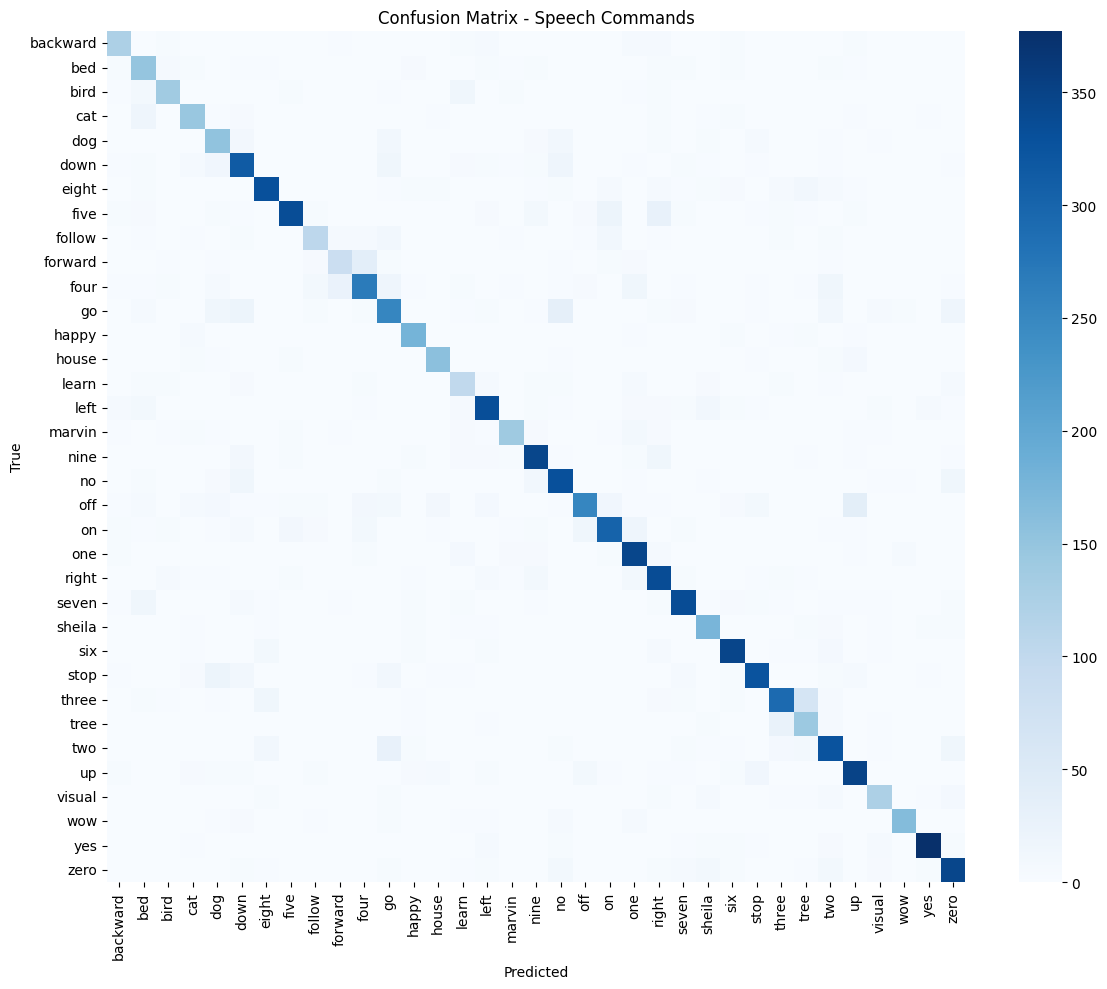

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=LABELS, digits=4)
with open("speechcmd_classification_report.txt", "w") as f:
    f.write(report)
mlflow.log_artifact("speechcmd_classification_report.txt")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap="Blues",
            xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Speech Commands")
plt.tight_layout()
plt.savefig("speechcmd_confusion_matrix.png", dpi=150)
plt.show()
plt.close()

> Generates, saves, and logs the classification report:
> 1.  Creates the report string using `classification_report` and the `LABELS` list for target names.
> 2.  Saves the report to `speechcmd_classification_report.txt`.
> 3.  Logs the report file as an MLflow artifact.


In [ ]:
mlflow.log_artifact("speechcmd_confusion_matrix.png")

In [ ]:
mlflow.end_run()

> Creates, visualizes, saves, and logs the confusion matrix:
> 1.  Computes the confusion matrix.
> 2.  Creates a heatmap visualization using `seaborn.heatmap`. `annot=False` is used as annotating cells might be too cluttered with many classes.
> 3.  Sets labels and title.
> 4.  Saves the plot to `speechcmd_confusion_matrix.png`.
> 5.  Displays the plot using `plt.show()`.
> 6.  Closes the plot figure using `plt.close()`.
> 7.  Logs the saved image file as an MLflow artifact.
> 8.  Ends the MLflow run.